# Diabetic Retinopathy Classification(with 100 images )

Importing all the required libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
data = pd.read_csv("G:\messider 1/Copy of Annotation_Base11.csv")

In [4]:
data.head()

,Image name,Ophthalmologic department,Retinopathy grade,Risk of macular edima
0,20051019_38557_0100_PP.tif,Service Ophtalmologie Lariboisière,3,1
1,20051020_43808_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0
2,20051020_43832_0100_PP.tif,Service Ophtalmologie Lariboisière,1,0
3,20051020_43882_0100_PP.tif,Service Ophtalmologie Lariboisière,2,0
4,20051020_43906_0100_PP.tif,Service Ophtalmologie Lariboisière,3,2


Creating target column 

In [5]:
data["Results"] = np.where((data["Retinopathy grade"]==0) & (data["Risk of macular edima"]==0),0,1)

In [6]:
train_labels = data[["Image name","Results"]]

In [7]:
print(train_labels.shape)
print(train_labels.head(2))

(100, 2)
                   Image name  Results
0  20051019_38557_0100_PP.tif        1
1  20051020_43808_0100_PP.tif        0


In [8]:
NUM_CLASSES = 2
# we need images of same size so we convert them into the size
WIDTH = 200
HEIGHT = 200
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 15
INIT_LR = 1e-3
Batch = 8
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []

In [9]:
def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    images = os.listdir(trainDir)
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(os.path.sep, trainDir, imageFileName)
        #print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  # Numpy array with shape (233,233,3)
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape) # 128,128,3
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr))
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
    return

In [10]:
from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
readTrainData("G:\messider 1\Base11")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now()))

Loading images at...2019-03-06 16:37:19.720304
Number of files in G:\messider 1\Base11 is 100
Loaded 100 images at...2019-03-06 16:37:56.915688


In [11]:
df = train_labels.copy()
print(df.columns)

Index(['Image name', 'Results'], dtype='object')


In [12]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) 

df2 = pd.DataFrame({'Image name': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) 
print(len(df2)) 

['Image name', 'data']
100


In [13]:
df2.head()

,Image name,data
0,20051019_38557_0100_PP.tif,"[[[0.0027529410287445667, 0.0, 0.0027529410287..."
1,20051020_43808_0100_PP.tif,"[[[0.00392156862745098, 0.0, 0.003921568627450..."
2,20051020_43832_0100_PP.tif,"[[[0.00861960766362209, 0.0007764705840279074,..."
3,20051020_43882_0100_PP.tif,"[[[0.0, 0.0, 0.0], [0.003560784283806296, 0.0,..."
4,20051020_43906_0100_PP.tif,"[[[0.0023372549636691223, 0.0, 0.0023372549636..."


In [14]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'Image name'] != df2.loc[df2.index[idx], 'Image name']):
        print("Error " + df.loc[df.index[idx], 'Image name'] +"==" + df2.loc[df2.index[idx], 'data'])
        
print(df2.dtypes)
print(df.dtypes)

Image name    object
data          object
dtype: object
Image name    object
Results        int32
dtype: object


In [15]:
df= pd.merge(df2, df, on="Image name", how='outer')
df_header_list = list(df.columns) 
print(df_header_list) 
print(len(df)) 
print(df.sample())

['Image name', 'data', 'Results']
100
                    Image name  \
19  20051020_44923_0100_PP.tif   

                                                 data  Results  
19  [[[0.004784313837687174, 0.0, 0.00478431383768...        1  


In [16]:
df.columns

Index(['Image name', 'data', 'Results'], dtype='object')

In [17]:
sample0 = df.loc[df.index[0], 'data']
print(sample0)
print(type(sample0)) 
print(sample0.shape) 

[[[0.00275294 0.         0.00275294]
  [0.00488627 0.         0.00488627]
  [0.00086275 0.         0.00086275]
  ...
  [0.00478431 0.         0.00478431]
  [0.00906667 0.00214118 0.00906667]
  [0.00086275 0.         0.00086275]]

 [[0.00470588 0.00039216 0.00470588]
  [0.00197647 0.0004     0.00197647]
  [0.01043137 0.0032549  0.01043137]
  ...
  [0.00266667 0.         0.00266667]
  [0.00421961 0.         0.00421961]
  [0.00784314 0.         0.00784314]]

 [[0.00705882 0.         0.00705882]
  [0.01141177 0.00380392 0.01141177]
  [0.         0.         0.        ]
  ...
  [0.00705882 0.         0.00705882]
  [0.00117647 0.         0.00117647]
  [0.00070588 0.         0.00070588]]

 ...

 [[0.01023529 0.00317647 0.01023529]
  [0.00862745 0.00235294 0.00862745]
  [0.00882353 0.00176471 0.00882353]
  ...
  [0.00196078 0.         0.00196078]
  [0.00654902 0.00117647 0.00654902]
  [0.0014902  0.         0.0014902 ]]

 [[0.00658824 0.00133333 0.00658824]
  [0.00517647 0.         0.00517647]


In [18]:
from matplotlib import pyplot as plt
plt.imshow(sample0,)
plt.show()
print("Sample Image")

<Figure size 640x480 with 1 Axes>

Sample Image


In [19]:
X = df['data']
Y = df['Results']


In [20]:
print(X.shape)
print(Y.shape)
print(df.columns)

(100,)
(100,)
Index(['Image name', 'data', 'Results'], dtype='object')


In [21]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(X,Y,test_size=0.25, random_state=10)

In [22]:
print("Trainx shape",trainX.shape)
print("valX shape",valX.shape)
print("trainY shape",trainY.shape)
print("valY shape",valY.shape)

Trainx shape (75,)
valX shape (25,)
trainY shape (75,)
valY shape (25,)


In [23]:
#trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
#valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [24]:
#construct the image generator for data augmentation
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [25]:
trainX = pd.DataFrame(trainX)
valX = pd.DataFrame(valX)
trainY = pd.DataFrame(trainY)
valY = pd.DataFrame(valY)

In [26]:
trainX.tail()

,data
89,"[[[0.0, 0.0, 0.0], [0.0023529412699680704, 0.0..."
28,"[[[0.00392156862745098, 0.0, 0.003921568627450..."
64,"[[[0.0017254901867286832, 0.0, 0.0017254901867..."
15,"[[[0.006117646834429572, 0.0, 0.00611764683442..."
9,"[[[0.0, 0.0, 0.0], [0.0012078431307100783, 0.0..."


In [27]:
print("Reshaping trainX at..."+ str(datetime.now()))
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) 
from numpy import zeros
Xtrain = np.zeros([75,HEIGHT, WIDTH, DEPTH])
#for i in range(75): 
    #Xtrain[i] = trainX[i]
print(Xtrain.shape)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2019-03-06 16:38:24.726655
<class 'pandas.core.frame.DataFrame'>
(75, 1)
(75, 200, 200, 3)
Reshaped trainX at...2019-03-06 16:38:24.726655


In [28]:
print("Reshaping trainX at..."+ str(datetime.now()))
print(type(valX)) # <class 'pandas.core.series.Series'>
print(valX.shape) 
from numpy import zeros
valX = np.zeros([25,HEIGHT, WIDTH, DEPTH])
#for i in range(75): 
    #Xtrain[i] = trainX[i]
print(valX.shape)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2019-03-06 16:38:24.820085
<class 'pandas.core.frame.DataFrame'>
(25, 1)
(25, 200, 200, 3)
Reshaped trainX at...2019-03-06 16:38:24.835709


# CNN model : self training 

In [29]:
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=1, activation='sigmoid'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
        # use categorical_crossentropy if there are more than two classes
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [30]:
print("compiling model...")
sys.stdout.flush()
model = createModel()

# print the summary of model
from keras.utils import print_summary
print_summary(model, line_length=None, positions=None, print_fn=None)


compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 198, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0 

C:\Users\anaconda\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`


In [31]:
Xtrain.shape

(75, 200, 200, 3)

In [32]:
# train the network
print("training network...")
sys.stdout.flush()
#class_mode ='categorical', # 2D one-hot encoded labels
H = model.fit(Xtrain,trainY,batch_size=8,epochs = 10,validation_data=(valX,valY))

training network...
Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 37s 495ms/step - loss: 0.6925 - acc: 0.6267 - val_loss: 0.6916 - val_acc: 0.6800
Epoch 2/10
75/75 [==============================] - 32s 431ms/step - loss: 0.6909 - acc: 0.6800 - val_loss: 0.6902 - val_acc: 0.6800
Epoch 3/10
75/75 [==============================] - 33s 438ms/step - loss: 0.6895 - acc: 0.6800 - val_loss: 0.6887 - val_acc: 0.6800
Epoch 4/10
75/75 [==============================] - 33s 435ms/step - loss: 0.6883 - acc: 0.6800 - val_loss: 0.6872 - val_acc: 0.6800
Epoch 5/10
75/75 [==============================] - 32s 433ms/step - loss: 0.6868 - acc: 0.6800 - val_loss: 0.6861 - val_acc: 0.6800
Epoch 6/10
75/75 [==============================] - 32s 428ms/step - loss: 0.6856 - acc: 0.6800 - val_loss: 0.6848 - val_acc: 0.6800
Epoch 7/10
75/75 [==============================] - 33s 436ms/step - loss: 0.6843 - acc: 0.6800 - val_loss: 0.6837 - val_acc: 0.6800
Epoch

# Tracking of 'loss and accuracy' vs 'epochs' 

Generating plots...


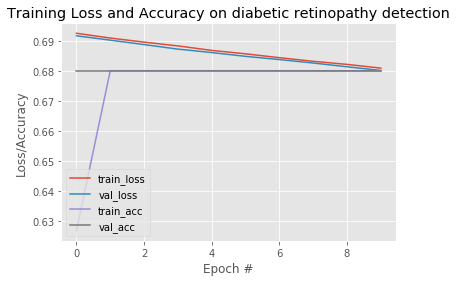

In [36]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, 10), H.history["acc"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, 10), H.history["val_acc"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

# Pretrained weights (Inception)

In [63]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='max_pool')(x)
x = Dropout(0.4)(x)

predictions = Dense(1, activation='sigmoid')(x)
model_inc = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model_inc.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:

history = model_inc.fit(Xtrain,trainY,validation_data=(valX,valY),epochs=10,batch_size=8)

Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 20s 271ms/step - loss: 0.6334 - acc: 0.6800 - val_loss: 0.6454 - val_acc: 0.6800
Epoch 2/10
75/75 [==============================] - 20s 269ms/step - loss: 0.6853 - acc: 0.6667 - val_loss: 0.6416 - val_acc: 0.6800
Epoch 3/10
75/75 [==============================] - 22s 288ms/step - loss: 0.6577 - acc: 0.6533 - val_loss: 0.6476 - val_acc: 0.6800
Epoch 4/10
75/75 [==============================] - 23s 304ms/step - loss: 0.6802 - acc: 0.6800 - val_loss: 0.6392 - val_acc: 0.6800
Epoch 5/10
75/75 [==============================] - 22s 295ms/step - loss: 0.6516 - acc: 0.6267 - val_loss: 0.6506 - val_acc: 0.6800
Epoch 6/10
75/75 [==============================] - 21s 282ms/step - loss: 0.6480 - acc: 0.6533 - val_loss: 0.6340 - val_acc: 0.6800
Epoch 7/10
75/75 [==============================] - 22s 288ms/step - loss: 0.7075 - acc: 0.6800 - val_loss: 0.6448 - val_acc: 0.6800
Epoch 8/10
75/75 [=======